<a href="https://colab.research.google.com/github/Jaquelinedops/CICIoT2023/blob/main/IoTTraffic_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador por assunto

Autores: Guilherme Bispo e Jaqueline Duarte

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
pip install parquet

In [13]:
# Importando classes e funções para modelos de classificação
import joblib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Importando classes e funções para pré-processamento de dados
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

# Importando métricas de avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importando classes e funções para divisão de dados e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score

# Importando bibliotecas para processamento de linguagem natural
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

# Importando bibliotecas de uso geral
import numpy as np
import pandas as pd
from collections import Counter

# Importando bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score

# Importando biblioteca para salvar e carregar modelos treinados
import joblib
from sklearn.metrics import confusion_matrix
# Importando a biblioteca de deep learning do TensorFlow
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt

import pandas
import numpy
import seaborn
import warnings
import gc
warnings.filterwarnings('ignore')
import os
import parquet
import time




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Importação do parquet - gerado em EDA_CICIoT23.ipynb

import parquet and reduce int type of boolean and integer data - Identified in EDA


In [11]:
#importação do dataset, ajuste de tipagem de dados para melhor uso de memória
#Análise Exploratória dos dados disponível em https://github.com/Jaquelinedops/CICIoT2023/blob/main/Analise%20de%20CICIoT23(1).ipynb

def read_dataset(path= "/content/drive/MyDrive/lab/CICIoT2023/",filename = "data.parquet", bool_col_list=[],int_col_list=[]):
  df = pandas.read_parquet(path + filename, engine='pyarrow', memory_map=True)
  gc.collect()
  df[bool_col_list] = df[bool_col_list].astype('int8')
  df[int_col_list] = df[int_col_list].astype('int32')
  gc.collect()
  return df

def generate_train_test_split(df, X_columns = [], test_size=0.2, random_state=10):
  X = df[X_columns]
  Y = df['label']
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, test_size=test_size)
  gc.collect()
  return X_train, X_test, Y_train, Y_test

def barh_plot(df, column_name = "label",lenght = 10, width = 10):
  labels = df[column_name].value_counts().index.to_list()
  composition = df[column_name].value_counts(normalize=True) * 100
  fig, ax = plt.subplots(figsize=(lenght, width))
  ax.barh(labels, composition, color='blue')
  ax.set_xlabel('Percentage', fontsize=16)
  ax.tick_params(labelsize=14)
  ax.set_ylabel('Label', fontsize=16)
  ax.set_title('Data Composition - Percentage of labeled data by class', fontsize=16)
  plt.show()

def calc_metrics(model_name = "model",y_true =[], y_pred=[], start_time=0, end_time=0, average = "weighted"):
  accuracy_clf = accuracy_score(Y_test, y_pred)
  recall = recall_score(Y_test, y_pred, average = average)
  f1 = f1_score(Y_test, y_pred, average = average)
  precision = precision_score(Y_test, y_pred,  average = average)

  results  = { 'model_name': model_name,
             'start_time': start_time,
             'end_time': end_time,
             'accuracy': accuracy_clf,
             'recall': recall,
             'precision':precision,
             'f1-score': f1}
  return results

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  plt.figure(figsize=(25, 25))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



The variables were selected as independent, dependent - calculated, boolean, integer as identified in EDA.py



In [8]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       ]

#dependent variables /calculated
X_columns_calc = ['Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',]

int_col_list = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
bool_col_list = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']


leitura do dataset parquet e preparação da base de treino e teste

In [12]:
path= "/content/drive/MyDrive/lab/CICIoT2023/"
filename = "data.parquet"
df = read_dataset(bool_col_list=bool_col_list,int_col_list=int_col_list)
X_train, X_test, Y_train, Y_test = generate_train_test_split(df, X_columns, test_size=0.2, random_state=10)


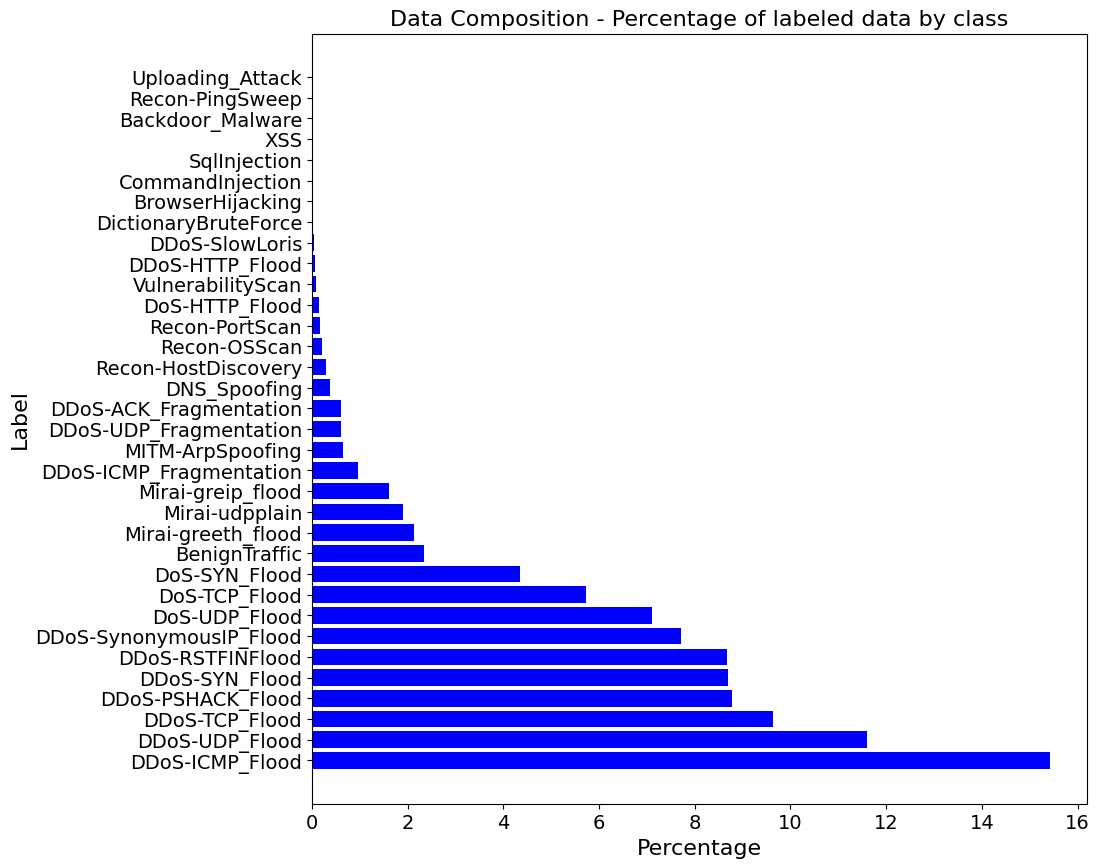

In [ ]:
#Distribuição dos dados
barh_plot(df, column_name = "label")

# Predicting models

# Data balancing
Cost-Sensitive Learning: Assigning higher weights to misclassifications of minority class examples during training, forcing the model to pay more attention to learning from them.




*   Calculate "Class_distribution" as the proportion of each class in dataset
*   A weight is attribute to each class label
the weight is calculated as the inverse proportion other distribution as classes in minor proportion get the major weight





In [18]:
# Calcular a distribuição de classes no conjunto de treino
class_distribution = Y_train.value_counts(normalize=True)
# Definir o peso para cada classe com base na sua distribuição
class_weights = {cls: 1 / proportion for cls, proportion in class_distribution.items()} # Create a dictionary mapping class labels to weights


A decision tree is a hierarchical model that divides the data space into increasingly smaller subsets, aiming to identify patterns and rules for classifying or predicting values of a target variable. Each node of the tree represents a decision, dividing the data into branches based on specific values of features.

Algorithm Steps:


*   Division Criterion Selection: A criterion is chosen that evaluates the quality of the division, such as entropy, information gain, or Gini impurity. The goal is to divide the data in a way that maximizes the purity of the classes in each node.
*   Tree Growth: The tree is built recursively, dividing the data at each node until a stopping criterion is reached, such as maximum depth, minimum number of samples in a node, or a satisfactory level of purity.
*  Tree Pruning: To avoid overfitting and improve generalization, pruning techniques can be applied, removing branches that do not significantly contribute to the accuracy of the model.





*   Accuracy : Accuracy measures the overall correctness of the model's predictions on a test dataset.
*   Precision: the ratio between the number of true positives and the total number of positive predictions made by the model (true positives and false positives).
*   Recall : is measure used to evaluate how much a model identify positive cases. average="Weighted": This argument specifies how the recall score is calculated across multiple classes, if applicable. "Weighted" means the recall is averaged weighted across all classes. Useful when for imbalanced class distributions and want  giving more weight to the majority class.

*    The F1-score is the harmonic mean between precision and recall. It is a commonly used metric in machine learning to evaluate the performance of a classifier, **particularly in binary classification tasks**.








Best" Splitting Strategy: searches for the feature and threshold that best separates the data at each node in the tree. It aims to maximize the information gain or Gini impurity reduction, leading to a more efficient and accurate decision tree.


In [19]:
DT = DecisionTreeClassifier(class_weight=class_weights, splitter='random')
start = time.time()
DT.fit(X_train, Y_train)
y_pred = DT.predict(X_test)
end = time.time()
time_elapsed = end - start

In [20]:
results = calc_metrics(model_name = "Decision_tree_balanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [ ]:
results

{'model_name': 'Decision_tree_balanced',
 'start_time': 1717478445.078003,
 'end_time': 1717478755.332272,
 'accuracy': 0.8197649088881644,
 'recall': 0.8197649088881644,
 'precision': 0.8344194043612393,
 'f1-score': 0.8213563290442475}

In [ ]:
score = DT.score(X_test,Y_test)
cm = confusion_matrix(Y_test, y_pred)

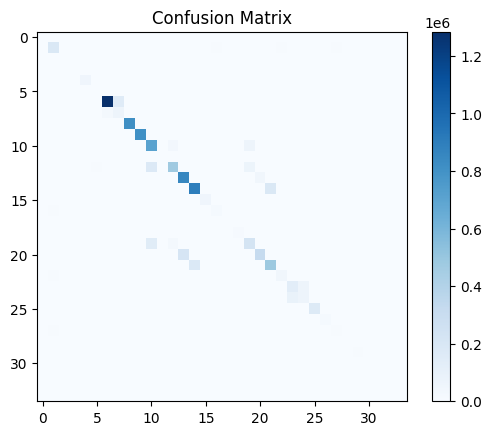

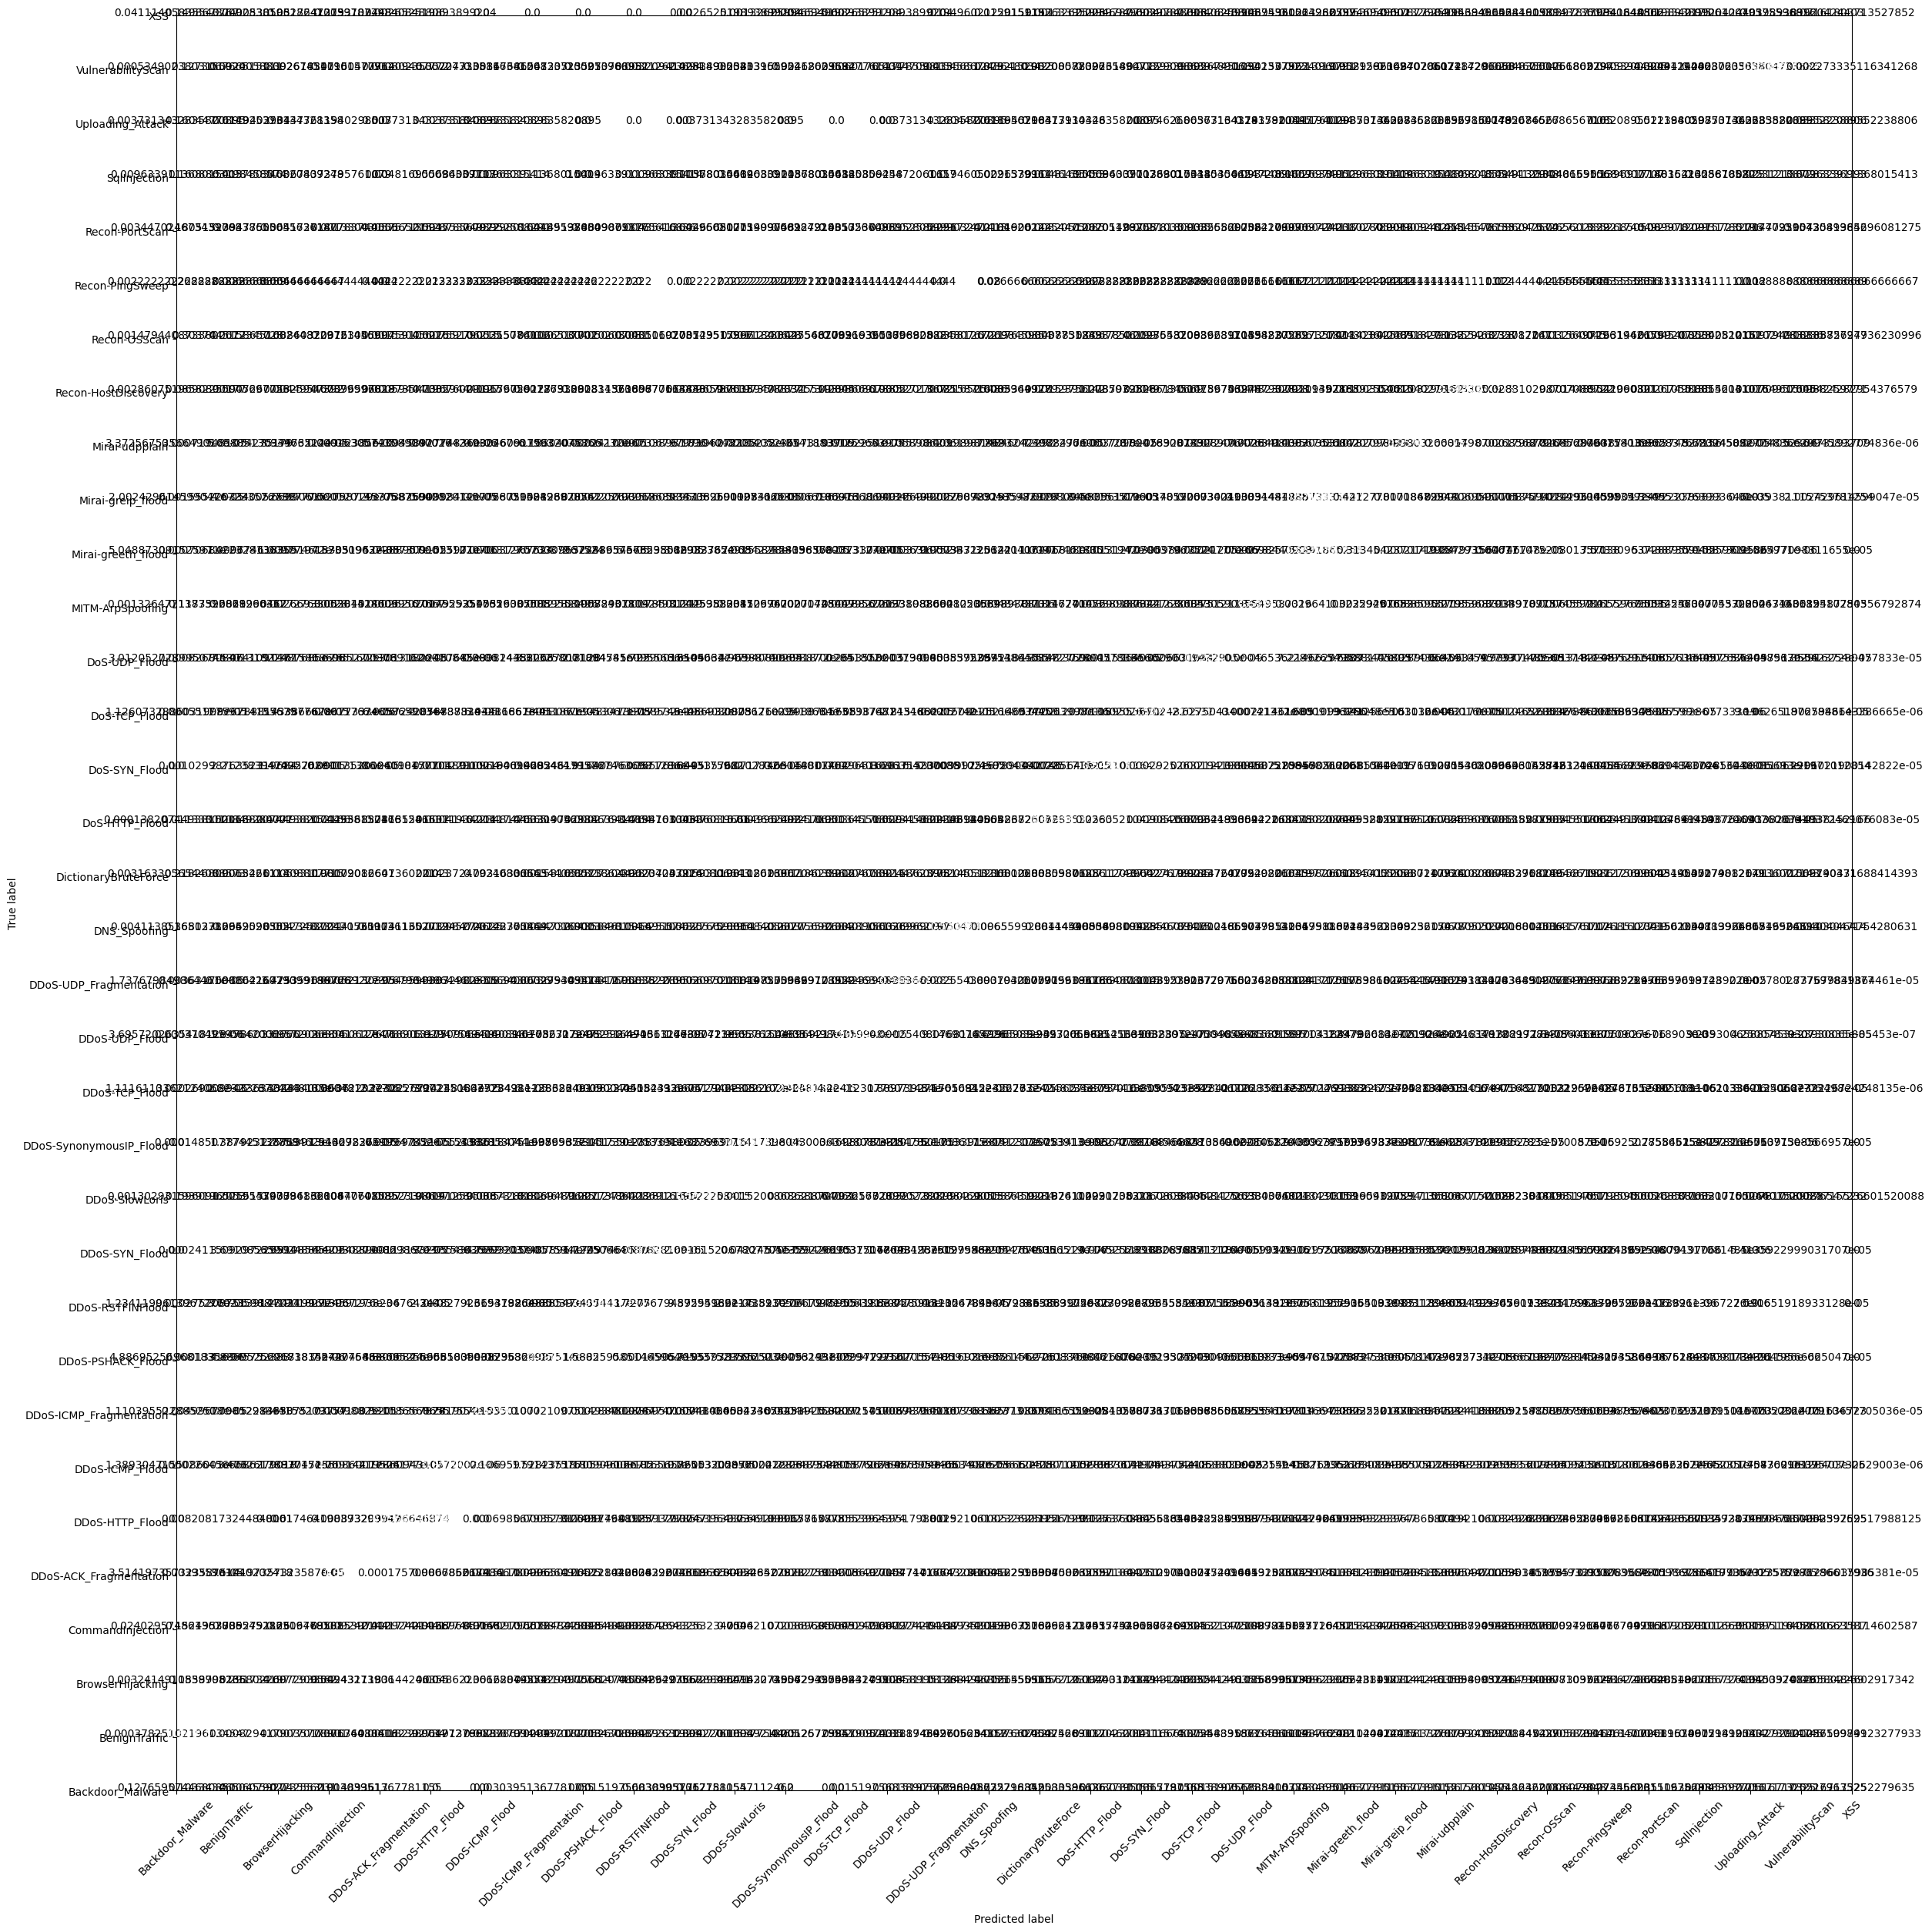

In [ ]:
categories = np.unique(np.concatenate((Y_test, y_pred)))
plot_confusion_matrix(cm, classes=categories, normalize=True, title='Confusion Matrix')


Setting the splitter argument to "random" is a strategy sometimes used to address this bias in imbalanced datasets.

In [14]:
DT_unbalanced = DecisionTreeClassifier(splitter='random')
start = time.time()
DT_unbalanced.fit(X_train, Y_train)
y_pred = DT_unbalanced.predict(X_test)
end = time.time()
time_elapsed = end - start


In [15]:
joblib.dump(DT_unbalanced, path +'Decision_tree_unbalanced.joblib')
results = calc_metrics(model_name = "Decision_tree_unbalanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [16]:
results

{'model_name': 'Decision_tree_unbalanced',
 'start_time': 1717506253.0780976,
 'end_time': 1717506509.3936412,
 'accuracy': 0.8370003756968276,
 'recall': 0.8370003756968276,
 'precision': 0.8421572933986596,
 'f1-score': 0.8303583260676727}

In [ ]:
from google.colab import runtime
runtime.unassign()